In [44]:
import torch
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.models import UNet2DModelWrapper
import json
import numpy as np

def load_model(save_dir, model_path, model_class):
    #read model hyperparameters
    with open(save_dir+'hyperparameters.json', 'r') as f:
        params = json.load(f)

    with open(save_dir+'losses.json', 'r') as f:
        losses = json.load(f)
    
    model_params = params['model_params']
    noise_params = params['noise_params']

    # load the model
    model = model_class(**model_params)
    model.load_state_dict(torch.load(save_dir+model_path))
    model.eval()
    noise_scheduler = DDPMScheduler(**noise_params)

    return model, noise_scheduler, params, losses

# read validation data from npy file
val_ds = np.load('../models/renko/unet2d_fixsplit/val_ds.npy')
print(val_ds.shape)

# unet1d, noise_scheduler, params, _ = load_model('../models/unet_128_0.001/', 'sst_sss_chl_minmax.pt', UNet1DModel)
# unet2d, noise_scheduler, _, _ = load_model('../models/unet2d_64_0.0005/', 'e20_32_32.pt', UNet2DModelWrapper)
# unet2d_renko, noise_scheduler, _, _= load_model('../models/renko/unet2d/', 'e50_64_32.pt', UNet2DModelWrapper)

unet2d_140, noise_scheduler_140, _, _= load_model('../models/renko/unet2d/', 'e140_64_32.pt', UNet2DModelWrapper)
unet2d_190, noise_scheduler_190, _, _= load_model('../models/renko/unet2d/', 'e_190.pt', UNet2DModelWrapper)
unet2d_120, noise_scheduler_100, _, _= load_model('../models/renko/unet2d_fixsplit/', 'e_120.pt', UNet2DModelWrapper)
unet2d_150, noise_scheduler_150, _, _= load_model('../models/renko/unet2d_fixsplit/', 'e_150.pt', UNet2DModelWrapper)
unet2d_200, noise_scheduler_200, _, _= load_model('../models/renko/unet2d_fixsplit/', 'e_200.pt', UNet2DModelWrapper)
unet2d_300, noise_scheduler_300, _, losses= load_model('../models/renko/unet2d_fixsplit/', 'e_300.pt', UNet2DModelWrapper)

models = dict({})
models['unet2d_140'] = dict({'model': unet2d_140, 'scheduler': noise_scheduler_140})
models['unet2d_190'] = dict({'model': unet2d_190, 'scheduler': noise_scheduler_190})

models['unet2d_120_fixsplit'] = dict({'model': unet2d_120, 'scheduler': noise_scheduler_100})
models['unet2d_150_fixsplit'] = dict({'model': unet2d_150, 'scheduler': noise_scheduler_150})
models['unet2d_200_fixsplit'] = dict({'model': unet2d_200, 'scheduler': noise_scheduler_200})
models['unet2d_300_fixsplit'] = dict({'model': unet2d_300, 'scheduler': noise_scheduler_300})
# uncond_unet1d, noise_scheduler = load_model('../models/unconditional_128_0.001/', 'e_50.pt', UNet1DModel)



(33768, 4, 64)


In [ ]:
train_losses = np.array(losses['train_losses'])
val_losses = np.array(losses['val_losses'])

min_epoch = np.argmin(train_losses)
print('min epoch:', min_epoch)
print('min train loss:', train_losses[min_epoch])


min_los_avg = np.mean(val_losses, axis=1)
min_epoch_val = np.argmin(min_los_avg)
print('min val loss epoch:', min_epoch_val)
print('min val loss:', min_los_avg[min_epoch_val])


min epoch: 284
min train loss: 0.022061293307136208
min val loss epoch: 117
min val loss: 0.07866493882650255


# Denoise sample from given noise level

In [62]:
def rec_sample(sample_context, model, noise_scheduler, timesteps):
    sample = torch.from_numpy(sample_context[0:1, :]).float()
    context = torch.from_numpy(sample_context[1:, :]).float()
    # add nan mask to the context
    nan_mask = ~torch.isnan(sample)
    context = torch.cat([context, nan_mask.float()], dim=0)

    nan_sample = torch.where(nan_mask, sample, torch.zeros_like(sample))
    # sample 100 times and plot the distribution of reconstructed fco2
    reconstructed_fco2s = []
    noisy_samples = []
    model.to('cpu')
    for _ in range(100):
        noise = torch.randn_like(nan_sample)
        noisy_sample = noise_scheduler.add_noise(nan_sample, noise, timesteps)
        input = torch.cat([noisy_sample, context], dim=0).unsqueeze(0)
        with torch.no_grad():
            output = model(input, timesteps)
    
        nan_fco2 = noise_scheduler.step(output[0], timesteps.item(), noisy_sample).pred_original_sample
        rec_fco2 = torch.where(nan_mask, nan_fco2, np.nan) # put in nans for better plotting
        reconstructed_fco2s.append(rec_fco2.numpy().flatten())
        # save noisy sample for plotting
        nan_noisy_sample = torch.where(nan_mask, noisy_sample, np.nan)
        noisy_samples.append(nan_noisy_sample.numpy().flatten())
    
    reconstructed_fco2s = np.array(reconstructed_fco2s)
    noisy_samples = np.array(noisy_samples)

    return reconstructed_fco2s, noisy_samples

def plot_rec(ax, recfco2s, noisy_samples, truth, title, plot_noisy=True):
    print('recfco2s shape:', recfco2s.shape)
    line01 = ax.plot(recfco2s.T[:,:10], color='blue', alpha=0.5)
    # plot devations from the mean
    print('recfco2s std:', recfco2s.std(axis=0))
    ax.fill_between(np.arange(0, 64), recfco2s.mean(axis=0) - recfco2s.std(axis=0),
                     recfco2s.mean(axis=0) + recfco2s.std(axis=0), color='blue', alpha=0.5)
    if plot_noisy:
        # plot noisy samples
        line02 = ax.plot(noisy_samples.T[:,:10], color='green', alpha=0.5)
    ax.plot(recfco2s.mean(axis=0), label='reconstructed fco2', color='blue')
    ax.plot(truth.flatten(), label='true fco2', color='red')
    if plot_noisy:
        ax.legend(handles=[line01[0], line02[0]], labels=['reconstructed fco2', 'noisy sample'])
    else:
        ax.legend(handles=[line01[0]], labels=['reconstructed fco2'])
    ax.set_title(title)
    ax.set_xlabel('distance')
    ax.set_ylabel('fco2')
    return ax


In [102]:
# sort samples by largest std
# ix = np.argsort(np.nanstd(val_ds[:, 0, :], axis=1))[::-1][100]
ix = 1234
sample = val_ds[ix]

1234
mean and std of the sample fco2: 0.18747061630404704, 0.23089376700001524
recfco2s shape: (100, 64)
recfco2s std: [       nan 0.04426948 0.04355972 0.04706312        nan 0.04538551
 0.04889004 0.05534966 0.05649875        nan 0.06472583 0.06127369
 0.04949089 0.0446328         nan 0.04020052 0.03935968 0.03848789
 0.04140189 0.03869048        nan 0.04146367 0.03908765 0.03905441
 0.0391648         nan 0.04015174 0.04131949 0.03918505 0.03846674
 0.04061292 0.0381229         nan 0.03967316 0.03269441 0.02894303
 0.03639759 0.0329712         nan 0.03777032 0.0338498  0.03403819
 0.02870691 0.0337561         nan 0.03385428 0.03309216 0.03440693
 0.03873407 0.03645572        nan 0.03549083 0.03645363 0.03560585
 0.03573734        nan 0.0387148  0.0378199  0.03242562 0.04125311
 0.03172844        nan 0.03276437 0.03701662]
recfco2s shape: (100, 64)
recfco2s std: [       nan 0.05694297 0.05325076 0.0576144         nan 0.07444295
 0.06832714 0.08255193 0.06806089        nan 0.07804529 0.

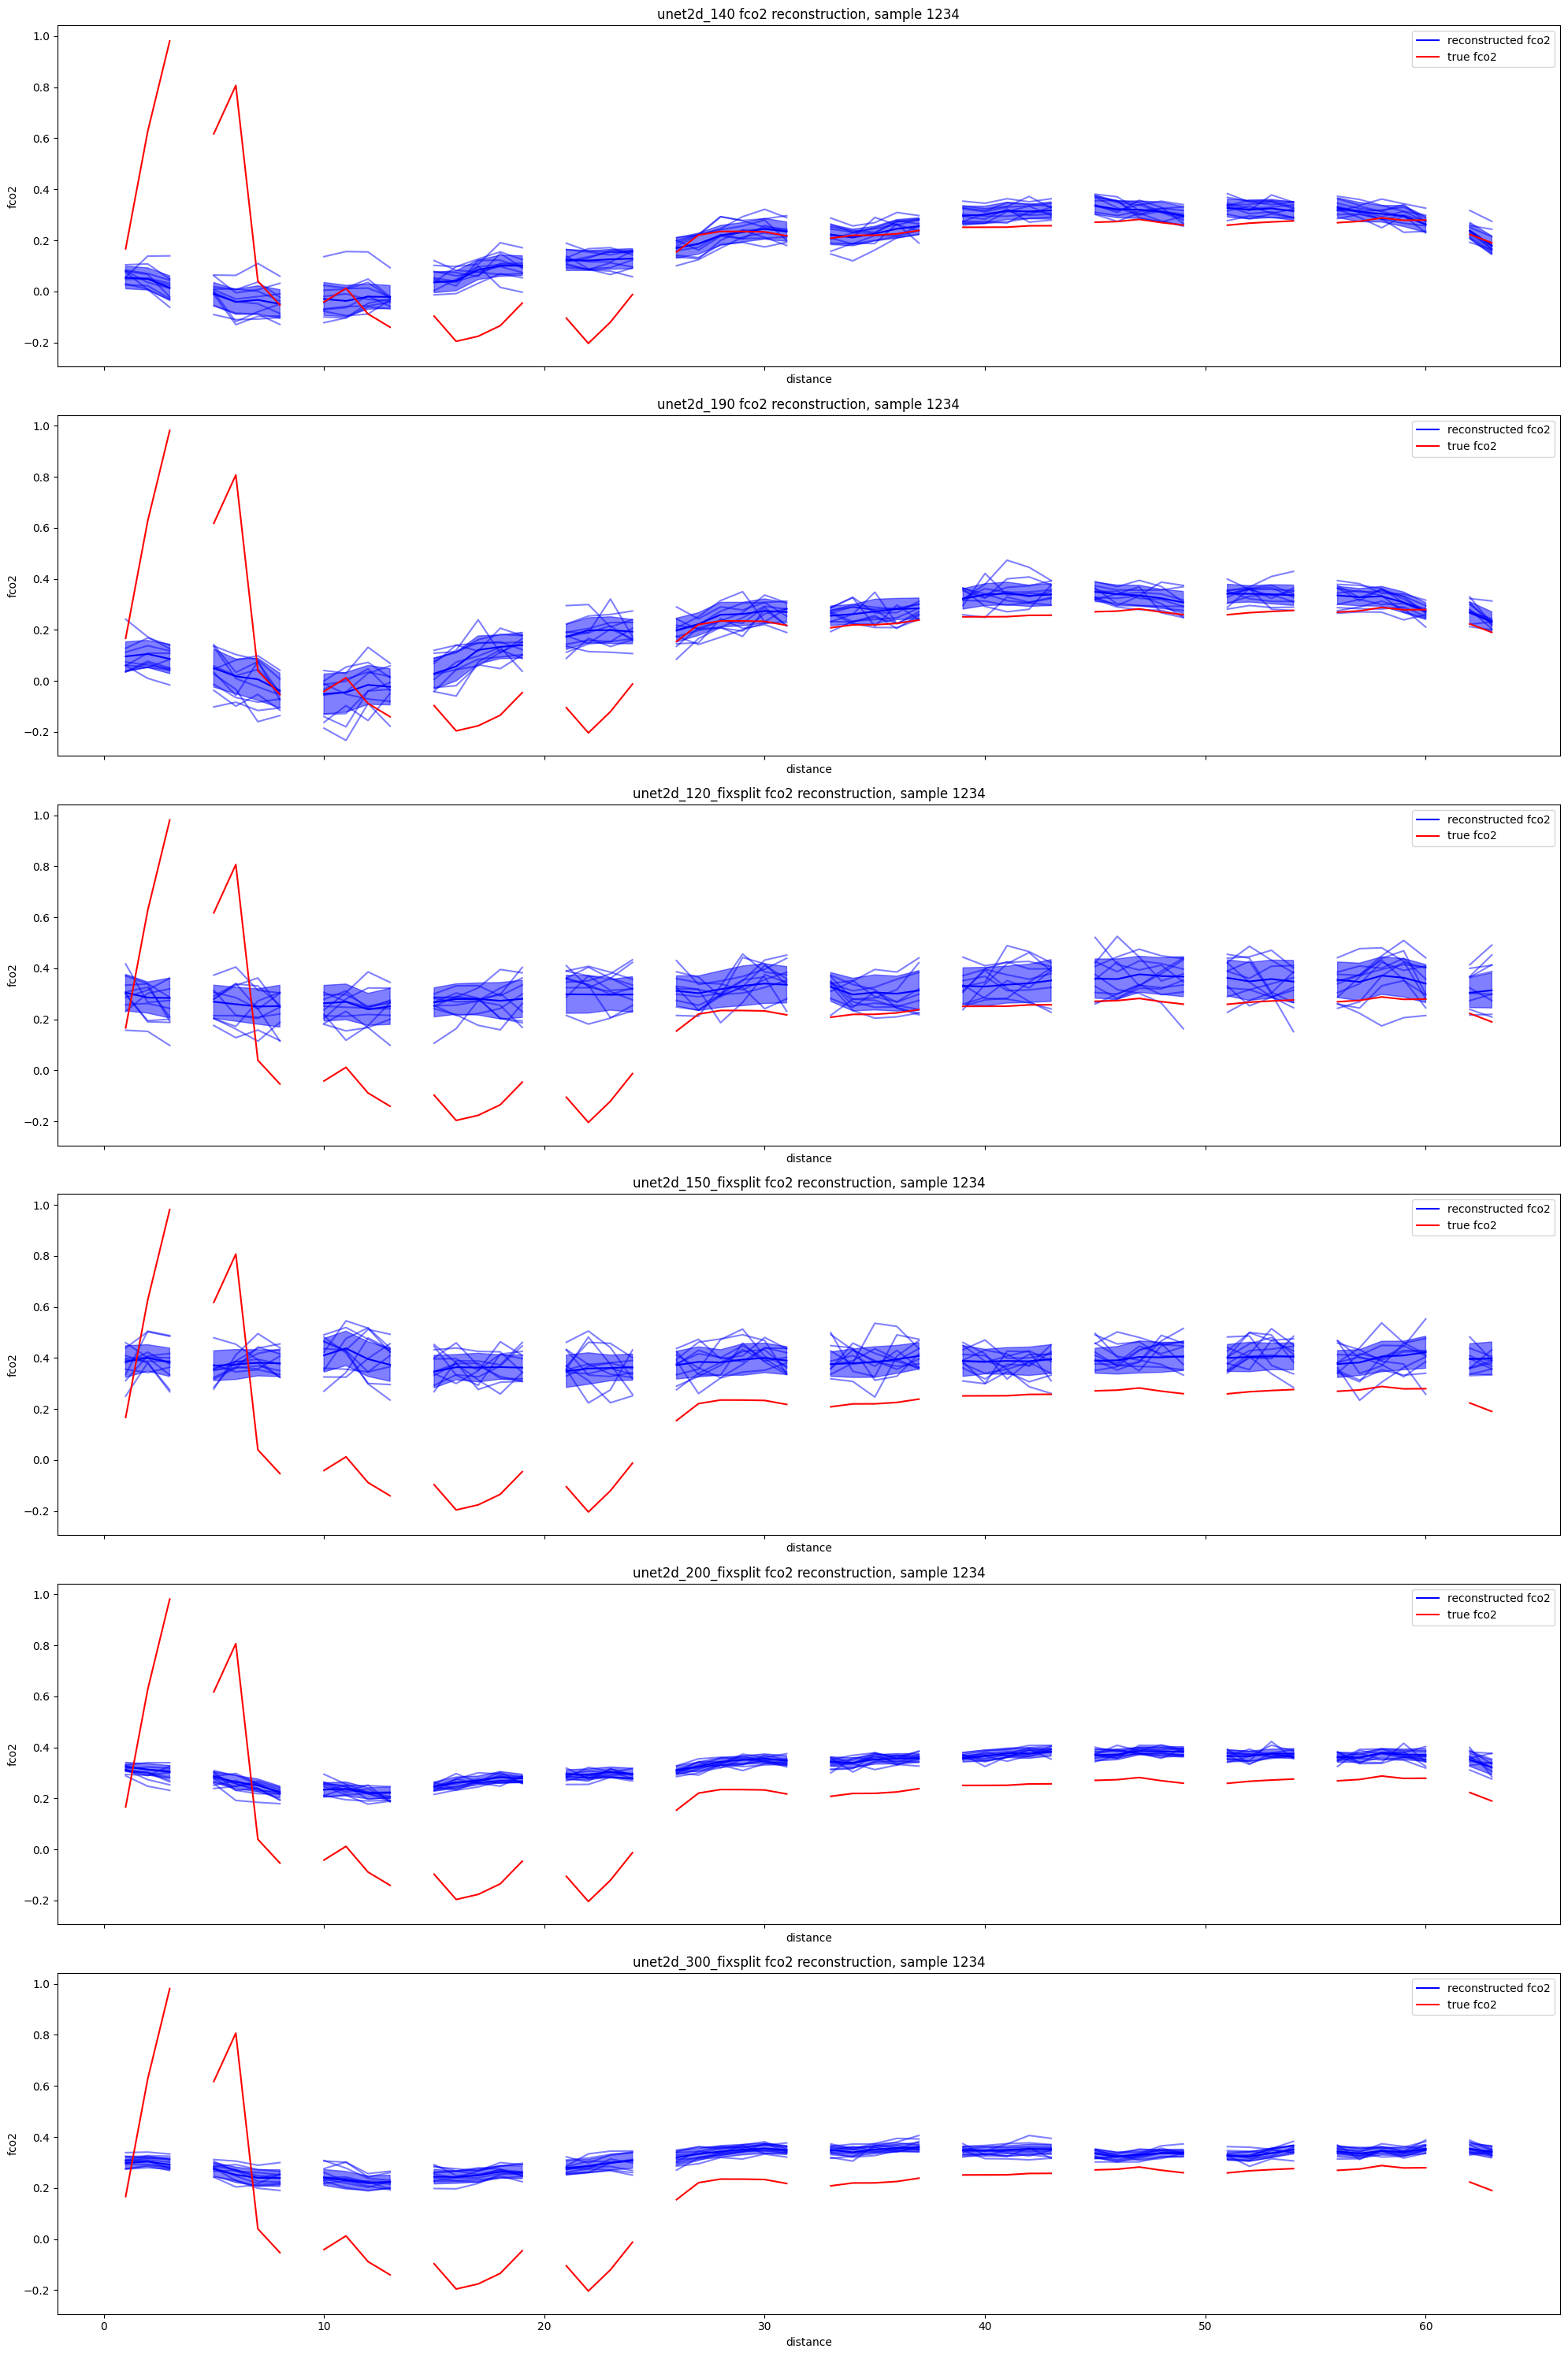

In [103]:
import numpy as np
import matplotlib.pyplot as plt


print(ix)
print(f"mean and std of the sample fco2: {np.nanmean(val_ds[ix, 0:1, :])}, {np.nanstd(val_ds[ix, 0:1, :])}")

sample = val_ds[ix]
timesteps = torch.tensor(900)

recs = dict()
for model_name, model in models.items():
    recs[model_name] = dict()
    recs[model_name]['rec'], recs[model_name]['noisy_samples'] = rec_sample(sample, model['model'], model['scheduler'], timesteps)


# plot the reconstruction
n_models = len(recs.keys())
fig, axs = plt.subplots(n_models, 1, figsize=(20, n_models*5), sharex=True, sharey=True)
for i, (model_name, rec) in enumerate(recs.items()):
    ax = plot_rec(axs[i], rec['rec'], rec['noisy_samples'], sample[0:1], f"{model_name} fco2 reconstruction, sample {ix}", plot_noisy=False)
    ax.legend()
    ax.set_title(f"{model_name} fco2 reconstruction, sample {ix}")
plt.tight_layout()
plt.show()

# Full denoising

In [104]:
# def one_full_denoising(sample_context, model, noise_scheduler, n_samples=10, timesteps=900):
#     # full denoising loop for a single sample
#     sample = torch.from_numpy(sample_context[0:1, :]).float()
#     context = torch.from_numpy(sample_context[1:, :]).float()
#     # add nan mask to the context
#     nan_mask = torch.ones_like(sample)
#     context = torch.cat([context, nan_mask.float()], dim=0)
#     nan_sample = torch.where(~torch.isnan(sample), sample, torch.zeros_like(sample))


#     print(sample.shape, context.shape)
#     samples = []
#     for ix in range(n_samples):
#         print(ix)
#         # sample = noise_scheduler.add_noise(nan_sample, noise, torch.tensor(300))
#         sample = noise_scheduler.add_noise(nan_sample, torch.randn_like(nan_sample), timesteps)
#         for i, t in enumerate(noise_scheduler.timesteps):
#             # concat noise, context
#             sample_context = torch.cat([sample, context], dim=0).unsqueeze(0)
        
#             # Get model pred
#             with torch.no_grad():
#                 residual = model(sample_context, t, return_dict=False)[0]
        
#             # Update sample with step
#             sample = noise_scheduler.step(residual, t, sample).prev_sample.squeeze(0)
#         samples.append(sample)

#     samples = torch.stack(samples, dim=0)
#     return samples

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def one_full_denoising(truth_context, model, noise_scheduler, n_samples=10, timesteps=900):
    # full denoising loop for a single sample
    # sample = torch.from_numpy(sample_context[0:1, :]).float()
    truth_context = torch.from_numpy(truth_context).float()
    context = truth_context[1:, :]
    # add nan mask to the context
    nan_mask = torch.ones_like(truth_context[0:1, :])
    context = torch.cat([context, nan_mask.float()], dim=0)
    
    sample = torch.randn_like(truth_context[0:1, :]).unsqueeze(0).repeat(n_samples, 1, 1)
    context = context.unsqueeze(0).repeat(n_samples, 1, 1)
    sample_context_ds = TensorDataset(torch.cat([sample, context], dim=1))
    loader = DataLoader(sample_context_ds, batch_size=64, shuffle=False)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    print("model device:", model.device)
    samples = []

    loader = tqdm(loader, desc="Denoising", total=len(loader))

    for batch in loader:
        sample_batch = batch[0][:, 0:1, :].to(device)
        context_batch = batch[0][:, 1:, :].to(device)
        for i, t in enumerate(noise_scheduler.timesteps):
            # concat noise, context
            sample_context_batch = torch.cat([sample_batch, context_batch], dim=1)
            # Get model pred
            with torch.no_grad():
                residual_batch = model(sample_context_batch, t, return_dict=False)[0]
        
            # Update sample with step
            sample_batch = noise_scheduler.step(residual_batch, t, sample_batch).prev_sample.squeeze(0)
            loader.set_postfix({"timestep": t.item()})
        # move to cpu
        # add to samples
        samples.append(sample_batch)

    samples = torch.cat(samples, dim=0)
    samples = samples.cpu().numpy()
    return samples

In [105]:
n_samples = 50
for model_name, model in models.items():
    recs[model_name]['full_denoising'] = one_full_denoising(sample, model['model'], model['scheduler'], n_samples=n_samples, timesteps=timesteps)

model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:34<00:00, 34.75s/it, timestep=0]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:35<00:00, 35.14s/it, timestep=0]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:35<00:00, 35.44s/it, timestep=0]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:35<00:00, 35.97s/it, timestep=0]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:35<00:00, 35.79s/it, timestep=0]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:35<00:00, 35.97s/it, timestep=0]


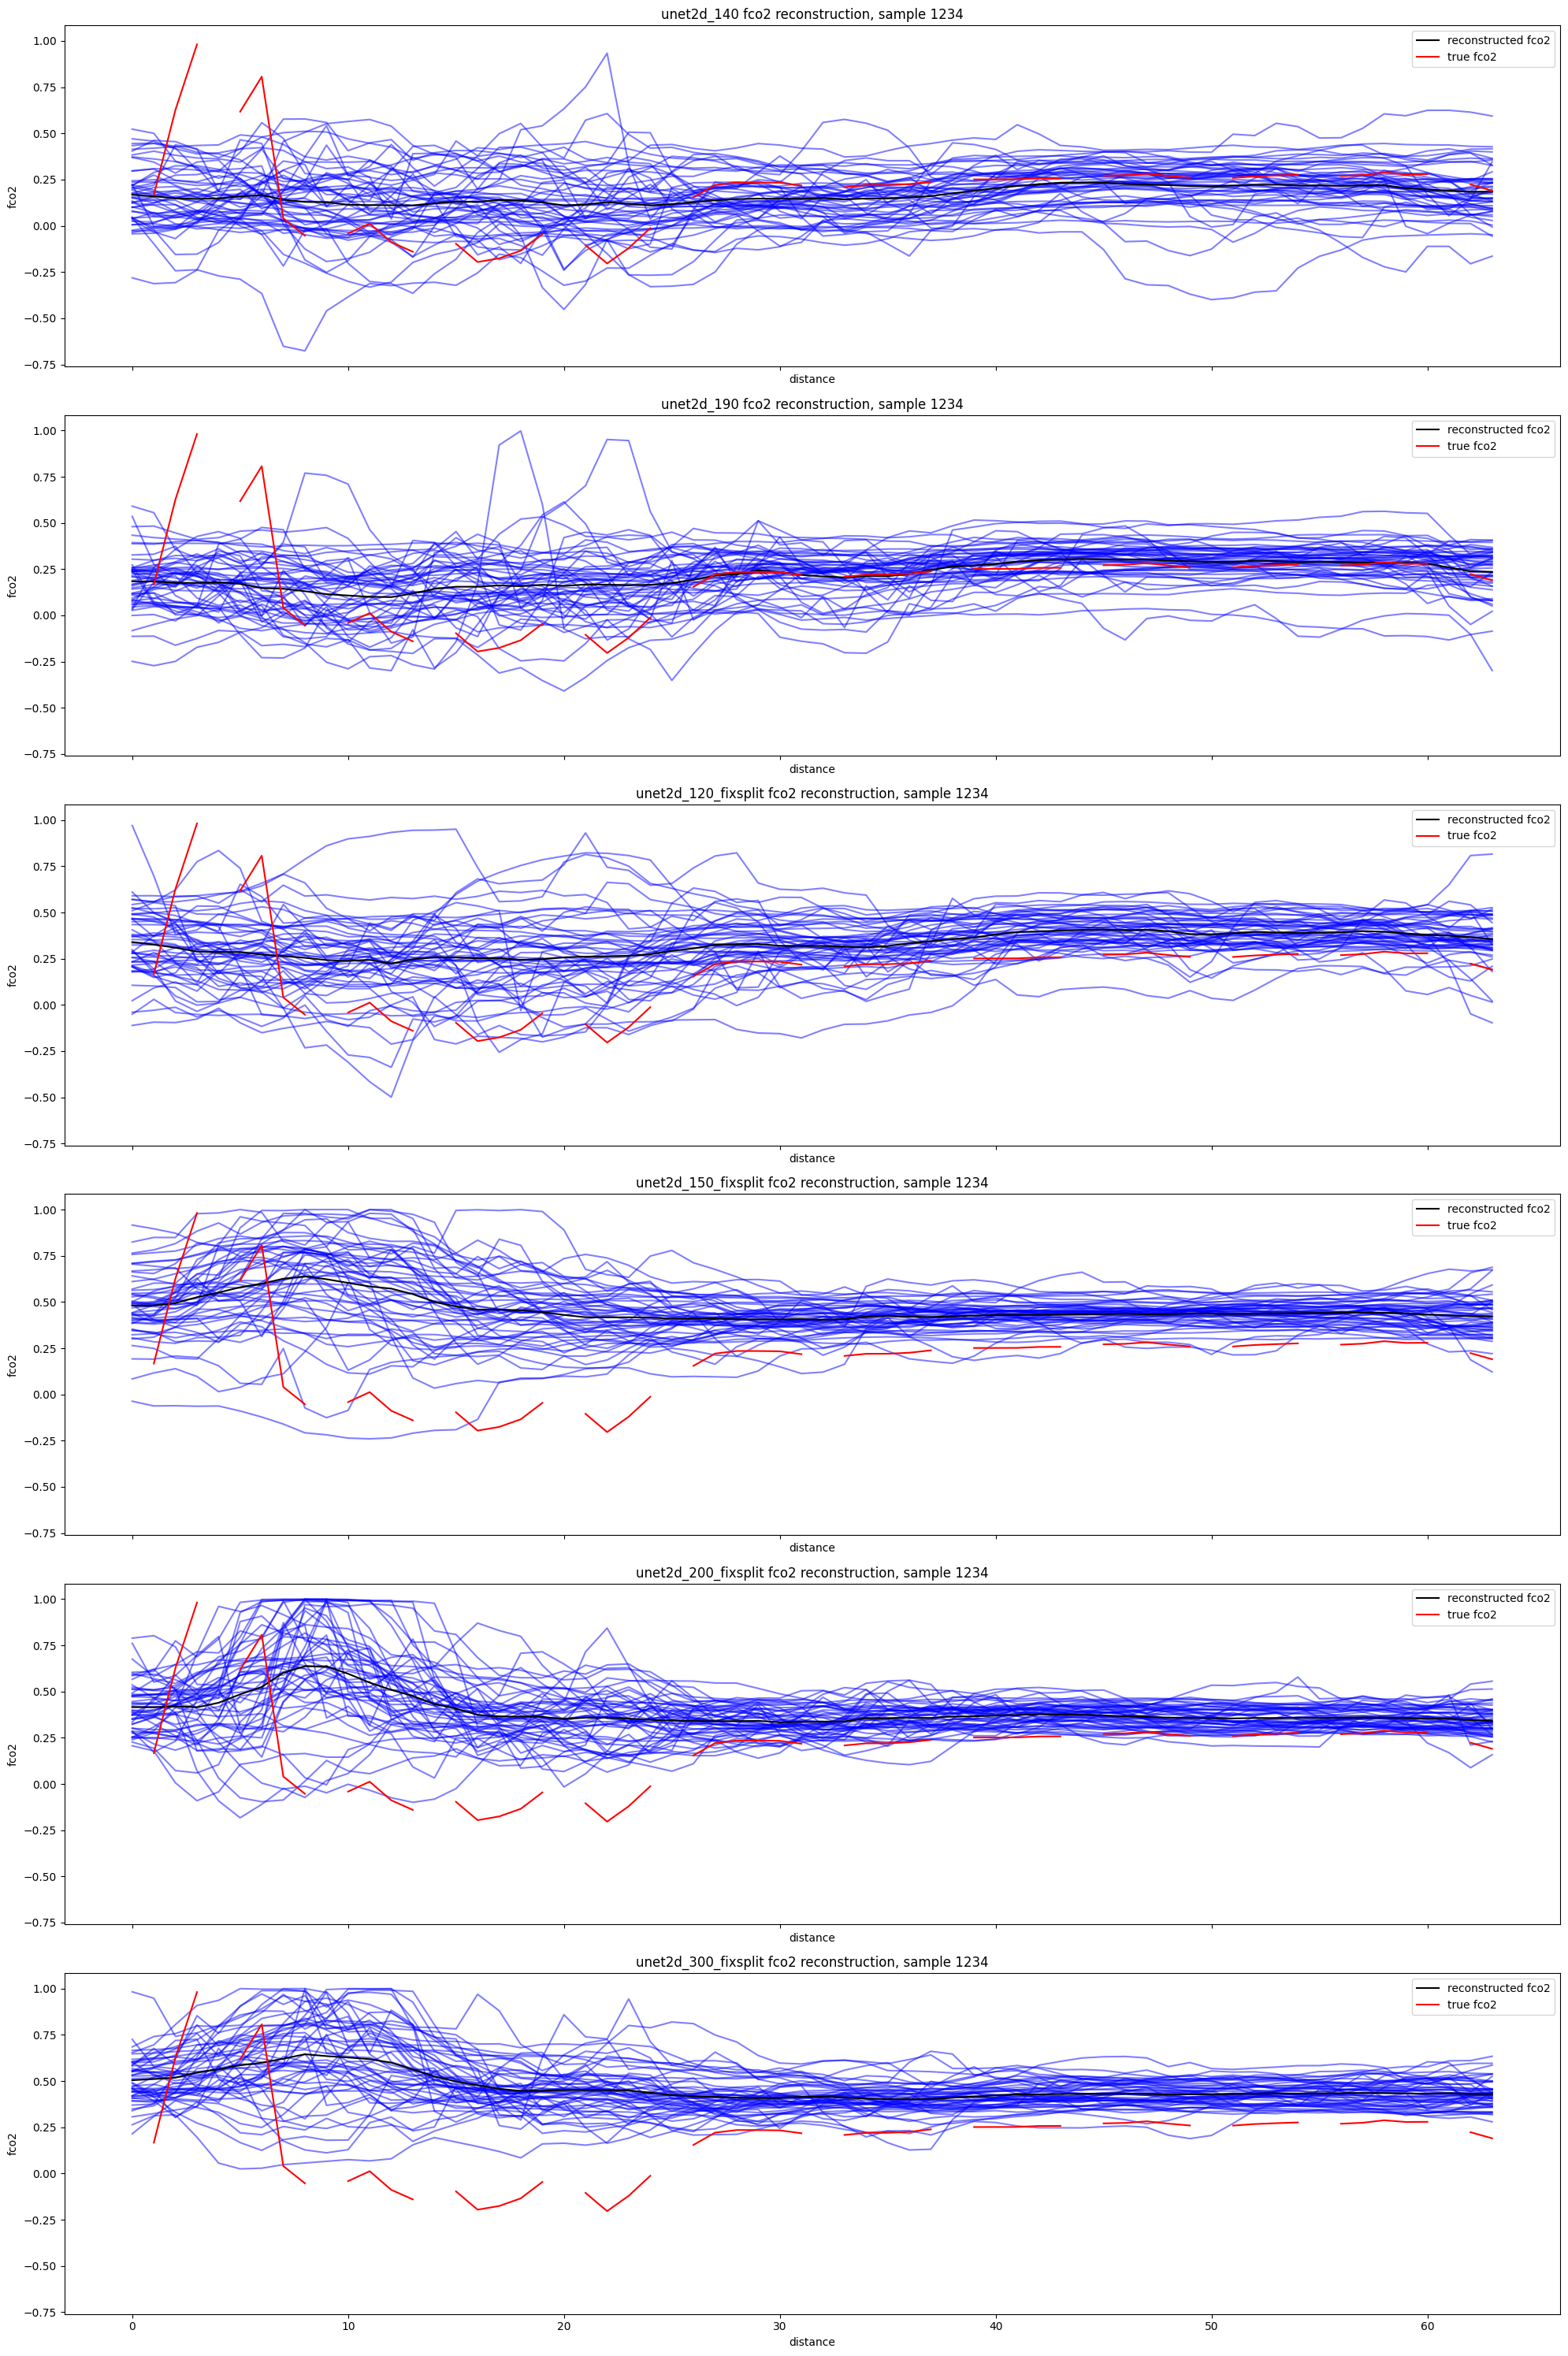

In [106]:
def picp(samples, fco2):
    y_hat_low = np.percentile(samples, 2.5, axis=0)
    y_hat_high = np.percentile(samples, 97.5, axis=0)

    return np.mean((y_hat_low < fco2) * (y_hat_high > fco2)) 

def plot_samples(ax, samples, truth, ix, model):
    ax.plot(samples.T, color='blue', alpha=0.5)
    ax.plot(samples.mean(axis=0), label='reconstructed fco2', color='black')
    ax.plot(truth.flatten(), label='true fco2', color='red')
    ax.set_title(f"{model} fco2 reconstruction, sample {ix}")
    ax.set_xlabel('distance')
    ax.set_ylabel('fco2')
    ax.legend()
# plot the samples

fig, axs = plt.subplots(n_models, 1, figsize=(20, 5 * n_models), sharex=True, sharey=True)
for i, (model_name, rec) in enumerate(recs.items()):
    plot_samples(axs[i], rec['full_denoising'].squeeze(1), sample[0:1, :], ix, model_name)
    axs[i].legend()
    axs[i].set_title(f"{model_name} fco2 reconstruction, sample {ix}")
    axs[i].set_xlabel('distance')
    axs[i].set_ylabel('fco2')
    axs[i].legend()

plt.tight_layout()

# Jump denoising

In [107]:
# import tensor dataset and loader
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
def one_jump_denoising(truth_context, model, noise_scheduler, n_samples=10, jump=10, timesteps=900):
    # full denoising loop for a single sample
    # sample = torch.from_numpy(sample_context[0:1, :]).float()
    truth_context = torch.from_numpy(truth_context).float()
    context = truth_context[1:, :]
    # add nan mask to the context
    nan_mask = torch.ones_like(truth_context[0:1, :])
    context = torch.cat([context, nan_mask.float()], dim=0)
    
    sample = torch.randn_like(truth_context[0:1, :]).unsqueeze(0).repeat(n_samples, 1, 1)
    context = context.unsqueeze(0).repeat(n_samples, 1, 1)
    sample_context_ds = TensorDataset(torch.cat([sample, context], dim=1))
    loader = DataLoader(sample_context_ds, batch_size=64, shuffle=False)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    print("model device:", model.device)
    samples = []

    loader = tqdm(loader, desc="Denoising", total=len(loader))

    for batch in loader:
        sample_batch = batch[0][:, 0:1, :].to(device)
        context_batch = batch[0][:, 1:, :].to(device)
        for i, t in enumerate(noise_scheduler.timesteps[::jump]):
            # concat noise, context
            sample_context_batch = torch.cat([sample_batch, context_batch], dim=1)
            # Get model pred
            with torch.no_grad():
                residual_batch = model(sample_context_batch, t, return_dict=False)[0]
        
            # Update sample with step
            x_0 = noise_scheduler.step(residual_batch, t, sample_batch).pred_original_sample.squeeze(0)
            if t < jump:
                sample_batch = x_0
            else:
                sample_batch = noise_scheduler.add_noise(x_0, torch.randn_like(sample_batch), t-jump)
            loader.set_postfix({"timestep": t.item()})
        # add to samples
        samples.append(sample_batch)

    samples = torch.cat(samples, dim=0)
    samples = samples.cpu().numpy()
    return samples

In [108]:

fco2 = torch.from_numpy(val_ds[ix, 0:1, :]).float().view(1, 1, -1)
nan_sample = torch.where(torch.isnan(fco2), torch.zeros_like(fco2), fco2)
context = torch.from_numpy(val_ds[ix, 1:, :]).float().view(1, -1, 64)
print(context.shape)
print(sample.shape)

jump = 5
for model_name, model in models.items():
    recs[model_name]['jump_denoising'] = one_jump_denoising(sample, model['model'], model['scheduler'], n_samples=50, jump=jump, timesteps=timesteps)

torch.Size([1, 3, 64])
(4, 64)
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:07<00:00,  7.29s/it, timestep=4]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:07<00:00,  7.14s/it, timestep=4]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:07<00:00,  7.21s/it, timestep=4]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it, timestep=4]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it, timestep=4]


model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:08<00:00,  8.30s/it, timestep=4]


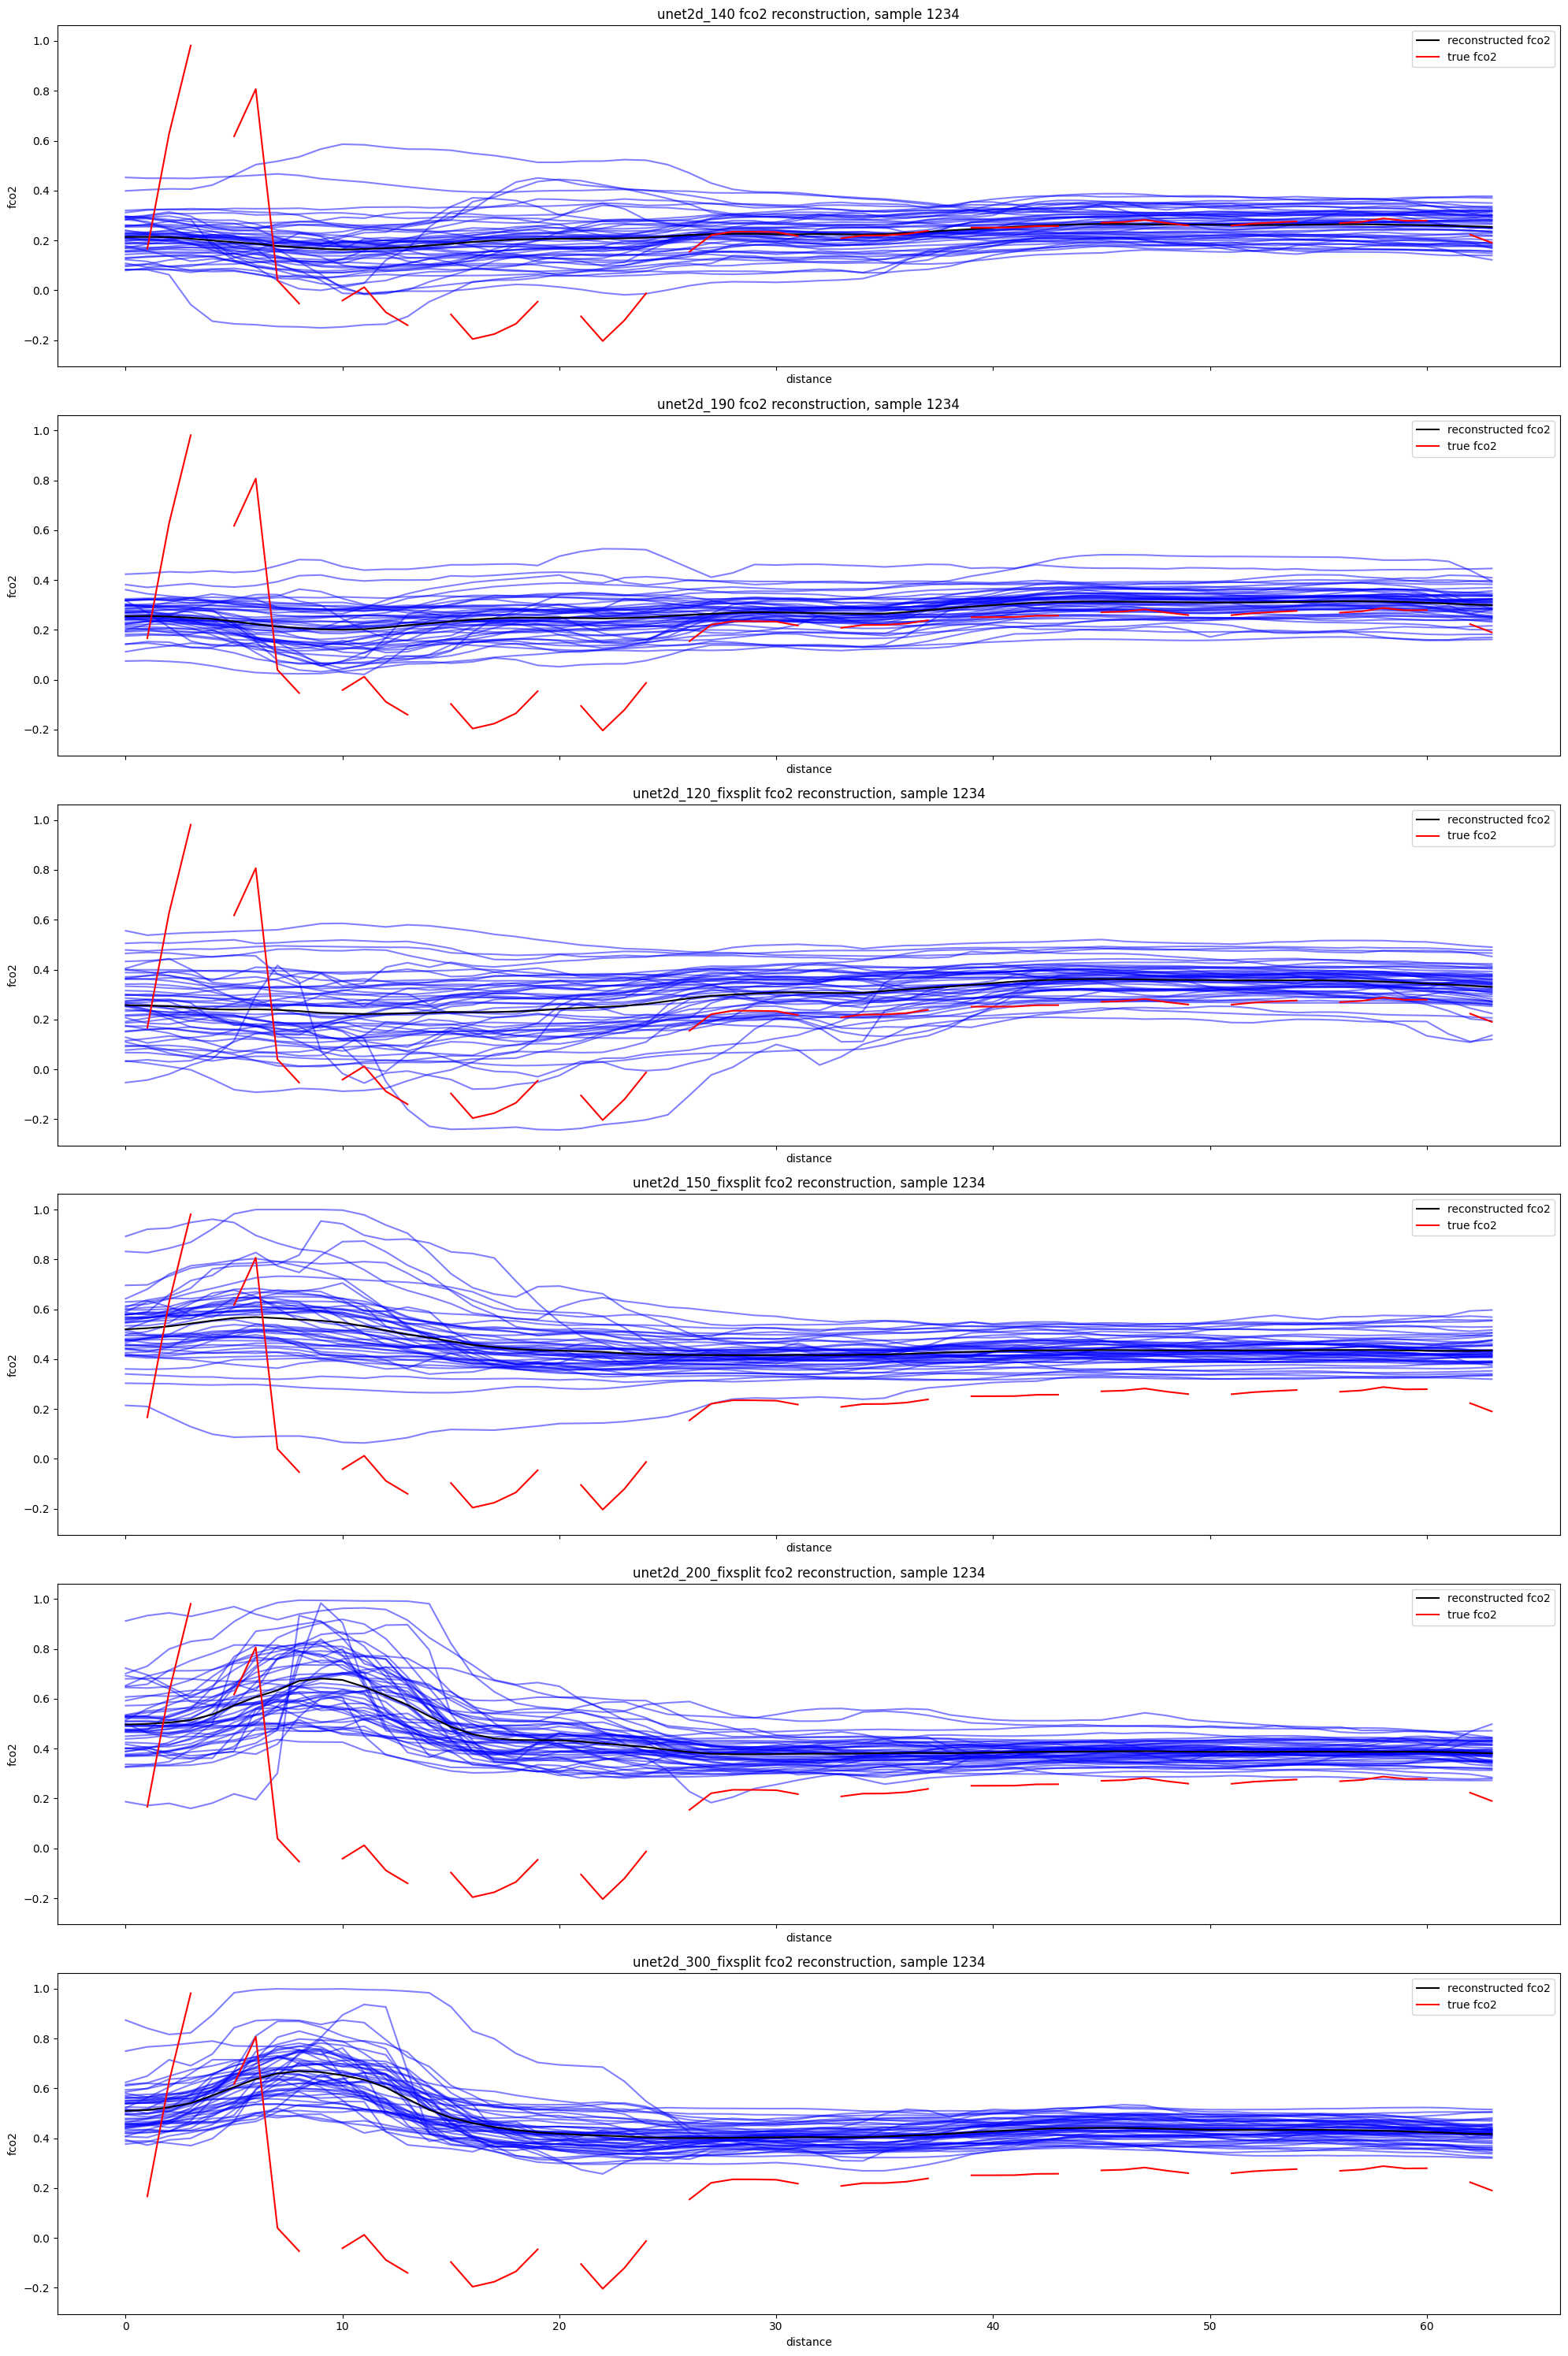

In [109]:
# plot the samples
fig, axs = plt.subplots(n_models, 1, figsize=(20, n_models*5), sharex=True, sharey=True)
# ax = plot_samples(axs[0], samples_1d.squeeze(1), sample[0:1, :], ix, "unet1d")
# ax = plot_samples(axs[1], samples_2d.squeeze(1), sample[0:1, :], ix, "unet2d")
# ax = plot_samples(axs[2], samples_2d_renko.squeeze(1), sample[0:1, :], ix, "unet2d_renko")
# ax = plot_samples(axs[3], samples_2d_renko140.squeeze(1), sample[0:1, :], ix, "unet2d_renko140")
# ax = plot_samples(axs[4], samples_2d_renko190.squeeze(1), sample[0:1, :], ix, "unet2d_renko190")
# plt.tight_layout()
# plt.show()
for i, (model_name, rec) in enumerate(recs.items()):
    plot_samples(axs[i], rec['jump_denoising'].squeeze(1), sample[0:1, :], ix, model_name)
    axs[i].legend()
    axs[i].set_title(f"{model_name} fco2 reconstruction, sample {ix}")
    axs[i].set_xlabel('distance')
    axs[i].set_ylabel('fco2')
    axs[i].legend()
plt.tight_layout()
plt.show()